In [1]:
from itertools import chain, combinations, filterfalse
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori as apriori2
from mlxtend.frequent_patterns import association_rules as association
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from time import time
import pickle
from functions import create_complex_test, evaluate_recommendations, get_sets
from hybrid_evaluation import evaluate_recommendations as hybrid_evaluation

# Preprocess Data

In [2]:
# read retail.dat to a list of sets
datContent = [i.strip().split() for i in open("../task1/retail.dat").readlines()]
datContent =  [[int(i) for i in datContent[j]] for j in range(len(datContent))]

# Convert to one hot encoded array
mlb = MultiLabelBinarizer()
one_hot_encoded = mlb.fit_transform(datContent)
one_hot_encoded = one_hot_encoded.astype(bool)
# Check for one-item baskets
basket_sizes = np.apply_along_axis(np.sum, axis=1, arr=one_hot_encoded)
# Get indices
indx = np.where(basket_sizes==1)[0]
# Remove one-item baskets
one_hot_encoded = np.delete(arr=one_hot_encoded, obj=indx, axis=0)
# split data
train, test = train_test_split(one_hot_encoded, test_size=0.1, random_state=23)
# create test output
test, test_output = create_complex_test(test)
# convert train data to datafram
train_dataframe = pd.DataFrame(train)
# get user items
user_items = get_sets(test, np.arange(len(test[0])))

# Save preprocessed data

In [8]:
# with open("test_output.pickle", "wb") as file:
#     pickle.dump(test_output, file)

# with open("test_baskets.pickle", "wb") as file:
#     pickle.dump(user_items, file)

# with open("train_baskets.pickle", "wb") as file:
#     pickle.dump(train, file)

# Read working data

In [2]:
with open("test_output.pickle", "rb") as file:
    test_output = pickle.load(file)

with open("test_baskets.pickle", "rb") as file:
    user_items = pickle.load(file)

with open("train_baskets.pickle", "rb") as file:
    train = pickle.load(file)
train_dataframe = pd.DataFrame(train)


# Threshold Evaluation for Lift, Confidence and Support

In [3]:
# Run apriori
min_sup = 0.005
top_n = 5
frq_items = apriori2(train_dataframe, min_support=min_sup, use_colnames=True)

# Define thresholds to investigate
thresholds = {"lift": np.arange(1, 3, 0.2), 
            "confidence": np.arange(0.3, 1, 0.1), 
            "support": np.arange(0.005, 0.1, 0.005)}
results_dict = {}

for met in thresholds.keys():
    # To store results
    precision_list = []
    recall_list = []
    f1_score_list = []

    # Collect rules for each threshold
    for i in thresholds[met]:
        rules_new = association(frq_items, metric = met, min_threshold = i)
        rules_new = rules_new.sort_values(met, ascending=False)
        final_rules = []
        # Convert format to use evaluate_recommendations function
        for i in range(len(rules_new)):
            antecedents, consequents, support, confidence, lift = rules_new.iloc[i]["antecedents"], rules_new.iloc[i]["consequents"], rules_new.iloc[i]["support"], rules_new.iloc[i]["confidence"], rules_new.iloc[i]["lift"]
            final_rules.append((antecedents, consequents, support, confidence, lift))

        precision, recall, f1_score = evaluate_recommendations(user_items, test_output, final_rules, met, top_n=top_n)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)

    combined_results = {"precision":precision_list,
                        "recall": recall_list,
                        "f1_score": f1_score_list}
    results_dict[met] = combined_results

# Get the final table with basic stats
metrics = {"lift": 1.5, "confidence": 0.6, "support": 0.05}
res = np.zeros((3,4))

for j, metric in enumerate(metrics.keys()):
    rules_new = association(frq_items, metric = metric, min_threshold = metrics[metric])
    final_rules = []

    for i in range(len(rules_new)):
        antecedents, consequents, support, confidence, lift = rules_new.iloc[i]["antecedents"], rules_new.iloc[i]["consequents"], rules_new.iloc[i]["support"], rules_new.iloc[i]["confidence"], rules_new.iloc[i]["lift"]
        final_rules.append((antecedents, consequents, support, confidence, lift))

    precision, recall, f1_score = evaluate_recommendations(user_items, test_output, final_rules, met, top_n=top_n)
    
    res[j,0] = precision
    res[j,1] = recall
    res[j,2] = f1_score
    res[j,3] = len(rules_new)

print(res)


[[1.30778396e-01 9.33151974e-02 1.08915312e-01 4.10000000e+02]
 [4.32334084e-01 7.07019184e-02 1.21529469e-01 3.49000000e+02]
 [1.77868375e-01 8.65425487e-02 1.16433786e-01 3.20000000e+01]]


# Evaluation of the Hybrid Score

In [4]:
# Use apriori algorithm to obtain frequent items
results_hybrid = {"precision":[], "recall":[], "f1_score":[]}

scaler = MinMaxScaler()
weights = np.array([0.33, 0.33, 0.33])

for j in np.arange(0.1, 0.7, 0.05):
    # Create association rules
    rules_new = association(frq_items, metric="confidence", min_threshold=0)
    # scale all metrics
    rules_normalized = scaler.fit_transform(rules_new.loc[:,["confidence", "lift", "support"]])
    # get hybrid measures
    rules_new["hybrid"] = rules_normalized @ weights
    rules_new = rules_new.sort_values("hybrid", ascending=False)
    rules_new = rules_new[rules_new["hybrid"]>j]

    final_rules = []
    for i in range(len(rules_new)):
        antecedents, consequents, support, confidence, lift, hybrid = rules_new.iloc[i]["antecedents"], rules_new.iloc[i]["consequents"], rules_new.iloc[i]["support"], rules_new.iloc[i]["confidence"], rules_new.iloc[i]["lift"], rules_new.iloc[i]["hybrid"]
        final_rules.append((antecedents, consequents, support, confidence, lift, hybrid))
        
    precision, recall, f1_score = hybrid_evaluation(user_items, test_output, final_rules, "hybrid", top_n=5)
    results_hybrid["precision"].append(precision)
    results_hybrid["recall"].append(recall)
    results_hybrid["f1_score"].append(f1_score)

# Plotting results

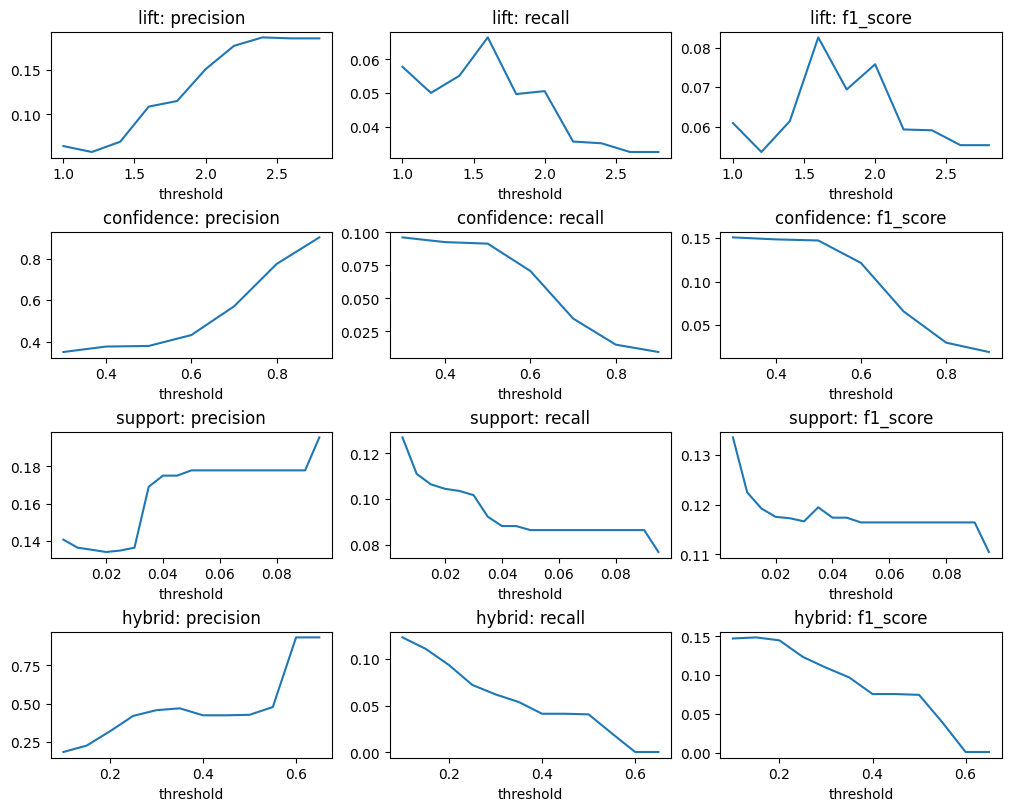

In [5]:
# Collect all results
results_dict["hybrid"] = results_hybrid
thresholds["hybrid"] = np.arange(0.1, 0.7, 0.05)

# Plotting threshold analysis
fig, axs = plt.subplots(4, 3, figsize=(10, 8), layout='constrained')
eval_metrics = ["precision", "recall", "f1_score"]

for x, metric in enumerate(results_dict.keys()):
    for y, eval in enumerate(eval_metrics):
        axs[x,y].set_title(metric + ": " + eval)
        axs[x,y].set_xlabel("threshold")
        axs[x,y].plot(thresholds[metric], results_dict[metric][eval])
plt.show()

# Table with final results

In [6]:
# Adding hybrid results to the table above
threshold = 0.3
rules_new = association(frq_items, metric = "confidence", min_threshold = 0)

rules_normalized = scaler.fit_transform(rules_new.loc[:,["confidence", "lift", "support"]])
rules_new["hybrid"] = rules_normalized @ weights
rules_new = rules_new.sort_values("hybrid", ascending=False)
rules_new = rules_new[rules_new["hybrid"]>threshold]
final_rules = []
for i in range(len(rules_new)):
    antecedents, consequents, support, confidence, lift, hybrid = rules_new.iloc[i]["antecedents"], rules_new.iloc[i]["consequents"], rules_new.iloc[i]["support"], rules_new.iloc[i]["confidence"], rules_new.iloc[i]["lift"], rules_new.iloc[i]["hybrid"]
    final_rules.append((antecedents, consequents, support, confidence, lift, hybrid))
    
precision, recall, f1_score = hybrid_evaluation(user_items, test_output, final_rules, "hybrid", top_n=5)

hybrid_res = np.array([[precision, recall, f1_score, len(rules_new)]])
full_res = np.concatenate((res, hybrid_res), axis=0)
res_df = pd.DataFrame(np.round(full_res,4), index=["lift", "confidence", "support", "hybrid"], columns=["precision", "recall", "f1_score", "nr_rules"])

res_df

,precision,recall,f1_score,nr_rules
lift,0.1308,0.0933,0.1089,410.0
confidence,0.4323,0.0707,0.1215,349.0
support,0.1779,0.0865,0.1164,32.0
hybrid,0.4564,0.0623,0.1096,48.0
